In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

import scipy.stats as stats
import pymc as pm
import arviz as az

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

sns.set_style("whitegrid")
import warnings
warnings.filterwarnings("ignore")

In [3]:
df_train = pd.read_csv(r'train_clf.csv')

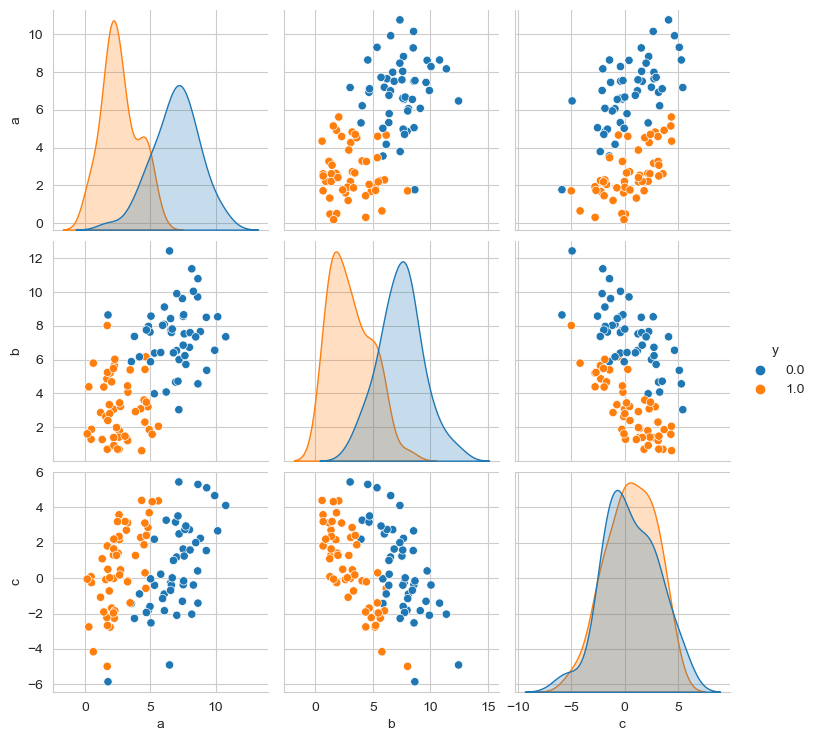

In [4]:
sns.pairplot(df_train, hue='y', diag_kind='kde');

In [5]:
columns = ['a', 'b', 'c']
X_train = df_train[columns].values
y_train = df_train['y']

In [6]:
X = df_train[columns]
X_transform = StandardScaler().fit_transform(X)

In [7]:
with pm.Model() as model_1:
    α = pm.Normal('α', mu=0, sigma=10)
    β = pm.StudentT('β', mu=0, sigma=2, nu=50, shape=len(columns))
    μ = α + pm.math.dot( X_transform,β)
    θ = pm.Deterministic('θ', pm.math.sigmoid(μ))

    bd = pm.Deterministic('bd', -α/β[1] - β[0]/β[1] * X_transform[:,0])

    yl = pm.Bernoulli('yl', p=θ, observed=y_train)

    trace_1 = pm.sample(3000, chains = 4, cores = 4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α, β]


Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 18 seconds.


In [8]:
varnames = ['α','β','bd']
az.summary(trace_1)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
α,-0.354,0.544,-1.428,0.622,0.007,0.005,7098.0,6545.0,1.0
β[0],-3.909,1.461,-6.900,-1.356,0.021,0.015,4815.0,5799.0,1.0
β[1],-3.445,1.457,-6.211,-0.699,0.021,0.015,4790.0,6434.0,1.0
β[2],-0.013,1.108,-2.061,2.062,0.017,0.012,4255.0,5209.0,1.0
θ[0],0.007,0.009,0.000,0.021,0.000,0.000,7985.0,7201.0,1.0
...,...,...,...,...,...,...,...,...,...
bd[95],1.027,23.141,-0.080,3.465,0.252,0.185,4680.0,6406.0,1.0
bd[96],-0.703,9.585,-2.016,0.072,0.098,0.069,5108.0,6310.0,1.0
bd[97],-1.098,16.883,-3.208,0.065,0.175,0.124,4838.0,5603.0,1.0
bd[98],1.576,33.406,-0.156,5.073,0.361,0.264,4627.0,6141.0,1.0


In [9]:
az.summary(trace_1, var_names=['α','β'] )

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
α,-0.354,0.544,-1.428,0.622,0.007,0.005,7098.0,6545.0,1.0
β[0],-3.909,1.461,-6.900,-1.356,0.021,0.015,4815.0,5799.0,1.0
β[1],-3.445,1.457,-6.211,-0.699,0.021,0.015,4790.0,6434.0,1.0
β[2],-0.013,1.108,-2.061,2.062,0.017,0.012,4255.0,5209.0,1.0


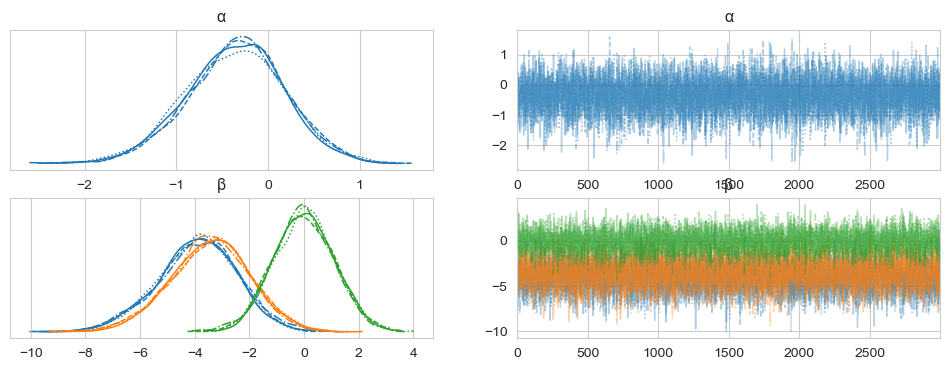

In [10]:
az.plot_trace(trace_1, var_names = ['α','β'],compact=True);

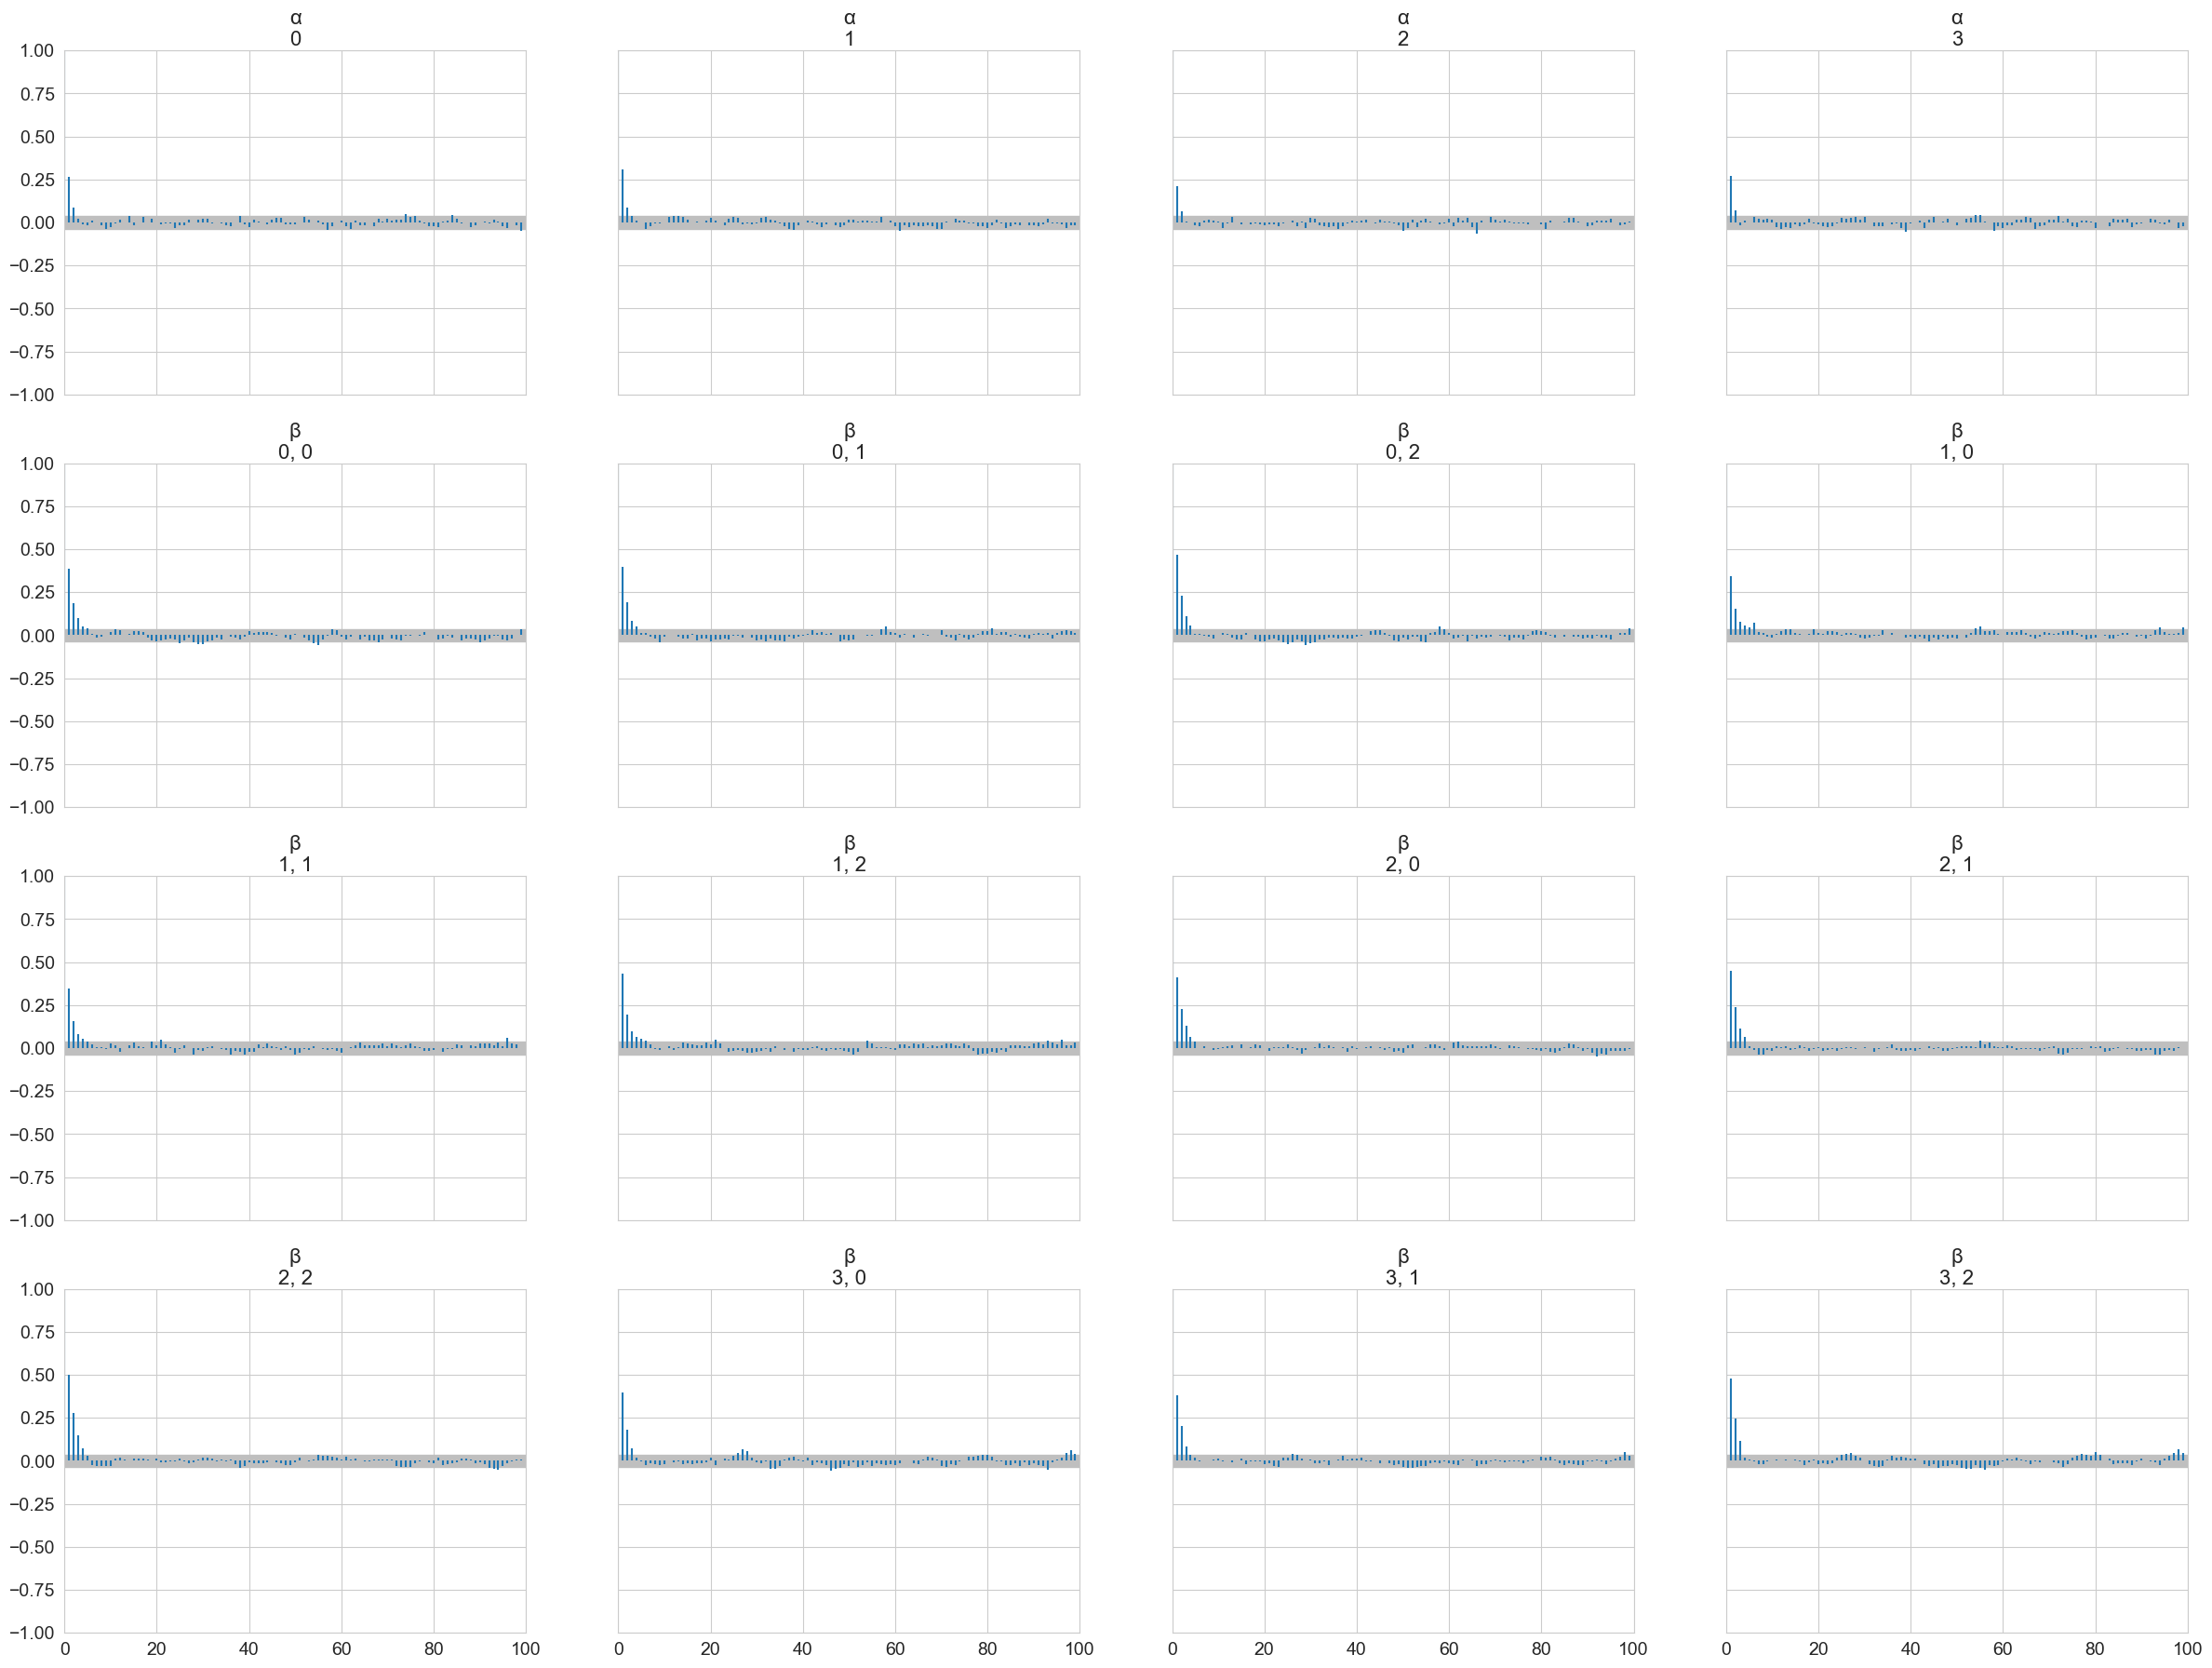

In [11]:
az.plot_autocorr(trace_1, ['α', 'β']);

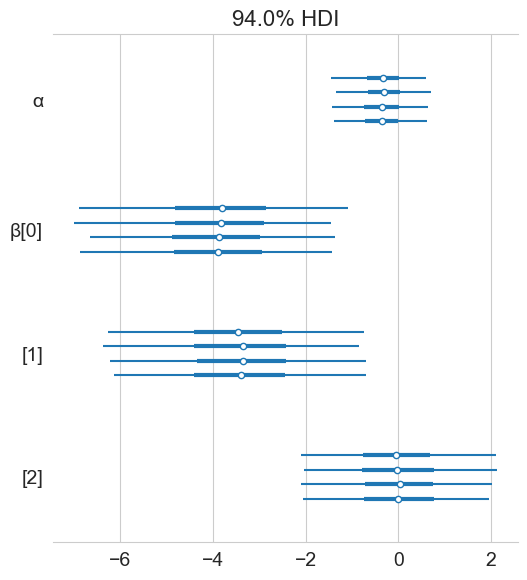

In [12]:
varnames = ['α', 'β']
az.plot_forest(trace_1, var_names=varnames);

предсказание на тестовом наборе

In [14]:
df_test = pd.read_csv(r"test_clf.csv")

In [15]:
X_1 = df_test[columns]
X_test_transformed = StandardScaler().fit_transform(X_1)

In [16]:
alpha = trace_1.posterior['α'].mean(("chain", "draw")).values
betta = trace_1.posterior["β"].mean(("chain", "draw")).values

zett= alpha + np.dot(X_test_transformed, betta)

predicted_probabilities = 1 / (1 + np.exp(-zett))

threshold = 0.3
pred = (predicted_probabilities > threshold).astype(int)

In [17]:
zett = alpha + np.dot(X_test_transformed, betta)

predict = 1 / (1 + np.exp(-zett))

threshold = 0.3
y_predict = (predict > threshold).astype(int)
y_predict

array([0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0,
       1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0,
       1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1,
       0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0,
       1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1])

In [19]:
from sklearn.metrics import accuracy_score
y_true = pd.read_csv('test_Y_true_clf.csv')
accuracy_score(y_true, y_predict)

0.95